# **Feature importance**

## **Data and Models Import**

In [6]:
%load_ext autoreload
%autoreload 2

import seaborn as sns
import shap
from datetime import datetime

from utils import *


datasets_folder = './datasets'
models_folder = './models'
figsize = (20,4)
verbosity = 0

tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


d:\GitHub\AII-project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[]


In [2]:
pollution_data = read_and_preprocess_dataset(datasets_folder, 'pollution', v=verbosity)
traffic_data = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity, radius=2)
weather_data = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

stations = list(pollution_data.keys())

In [3]:
station_data = {}
date_encoding = 'radial_months-sin-cos_days_hours'

for station in stations:
    station_data[station] = prepare_station_data_for_training(
        pollution_data[station], 
        traffic_data[station], 
        weather_data, 
        encoding_method=date_encoding,
        # weather merging parameters:
        aggregations = DEFAULT_AGGREGATIONS,
        max_min_columns = DEFAULT_MAX_MIN_COLUMNS, 
        # traffic merging parameters:
        bin_size = 3,
        offset = 0
        # bin_size = 8,
        # offset = 2
    )
    
    print(f'Station {station} agents: ',', '.join(list(station_data[station].keys())))

n_hour_features = len(station_data['GIARDINI MARGHERITA']['NO2'].columns) - 1 # -1 because Agent_value is the target
n_daily_features = len(station_data['GIARDINI MARGHERITA']['PM2.5'].columns) - 1 # -1 because Agent_value is the target
print(f'Total number of hourly features: {n_hour_features}')
print(f'Total number of daily features: {n_daily_features}')
agents = list(set(agent for station in stations for agent in station_data[station].keys()))

Station GIARDINI MARGHERITA agents:  NO2, O3, PM10, PM2.5
Station PORTA SAN FELICE agents:  C6H6, CO, NO2, PM10, PM2.5
Station VIA CHIARINI agents:  NO2, O3, PM10
Total number of hourly features: 24
Total number of daily features: 33


In [47]:
train_split_date = datetime(2023,12,31,23)
target = 'Agent_value'

train_sets = {}
test_sets = {}

for station in stations:
    train_sets[station] = {}
    test_sets[station] = {}
    for agent in station_data[station].keys():
        train_sets[station][agent] = {}
        test_sets[station][agent] = {}

        x_train, y_train, x_test, y_test = create_train_test(station_data[station][agent], train_split_date, y=target)

        train_sets[station][agent]['x'] = x_train
        train_sets[station][agent]['y'] = y_train
        test_sets[station][agent]['x'] = x_test
        test_sets[station][agent]['y'] = y_test

In [8]:
models = load_models(models_folder)

Loading model: GIARDINI MARGHERITA.NO2
Loading model: GIARDINI MARGHERITA.O3
Loading model: GIARDINI MARGHERITA.PM10
Loading model: GIARDINI MARGHERITA.PM2_5
Loading model: PORTA SAN FELICE.C6H6
Loading model: PORTA SAN FELICE.CO
Loading model: PORTA SAN FELICE.NO2
Loading model: PORTA SAN FELICE.PM10
Loading model: PORTA SAN FELICE.PM2_5
Loading model: VIA CHIARINI.NO2
Loading model: VIA CHIARINI.O3
Loading model: VIA CHIARINI.PM10


## **Explainability with Permutation Importance**

In [ ]:
from sklearn.inspection import permutation_importance

agents_permutation_importance = {}

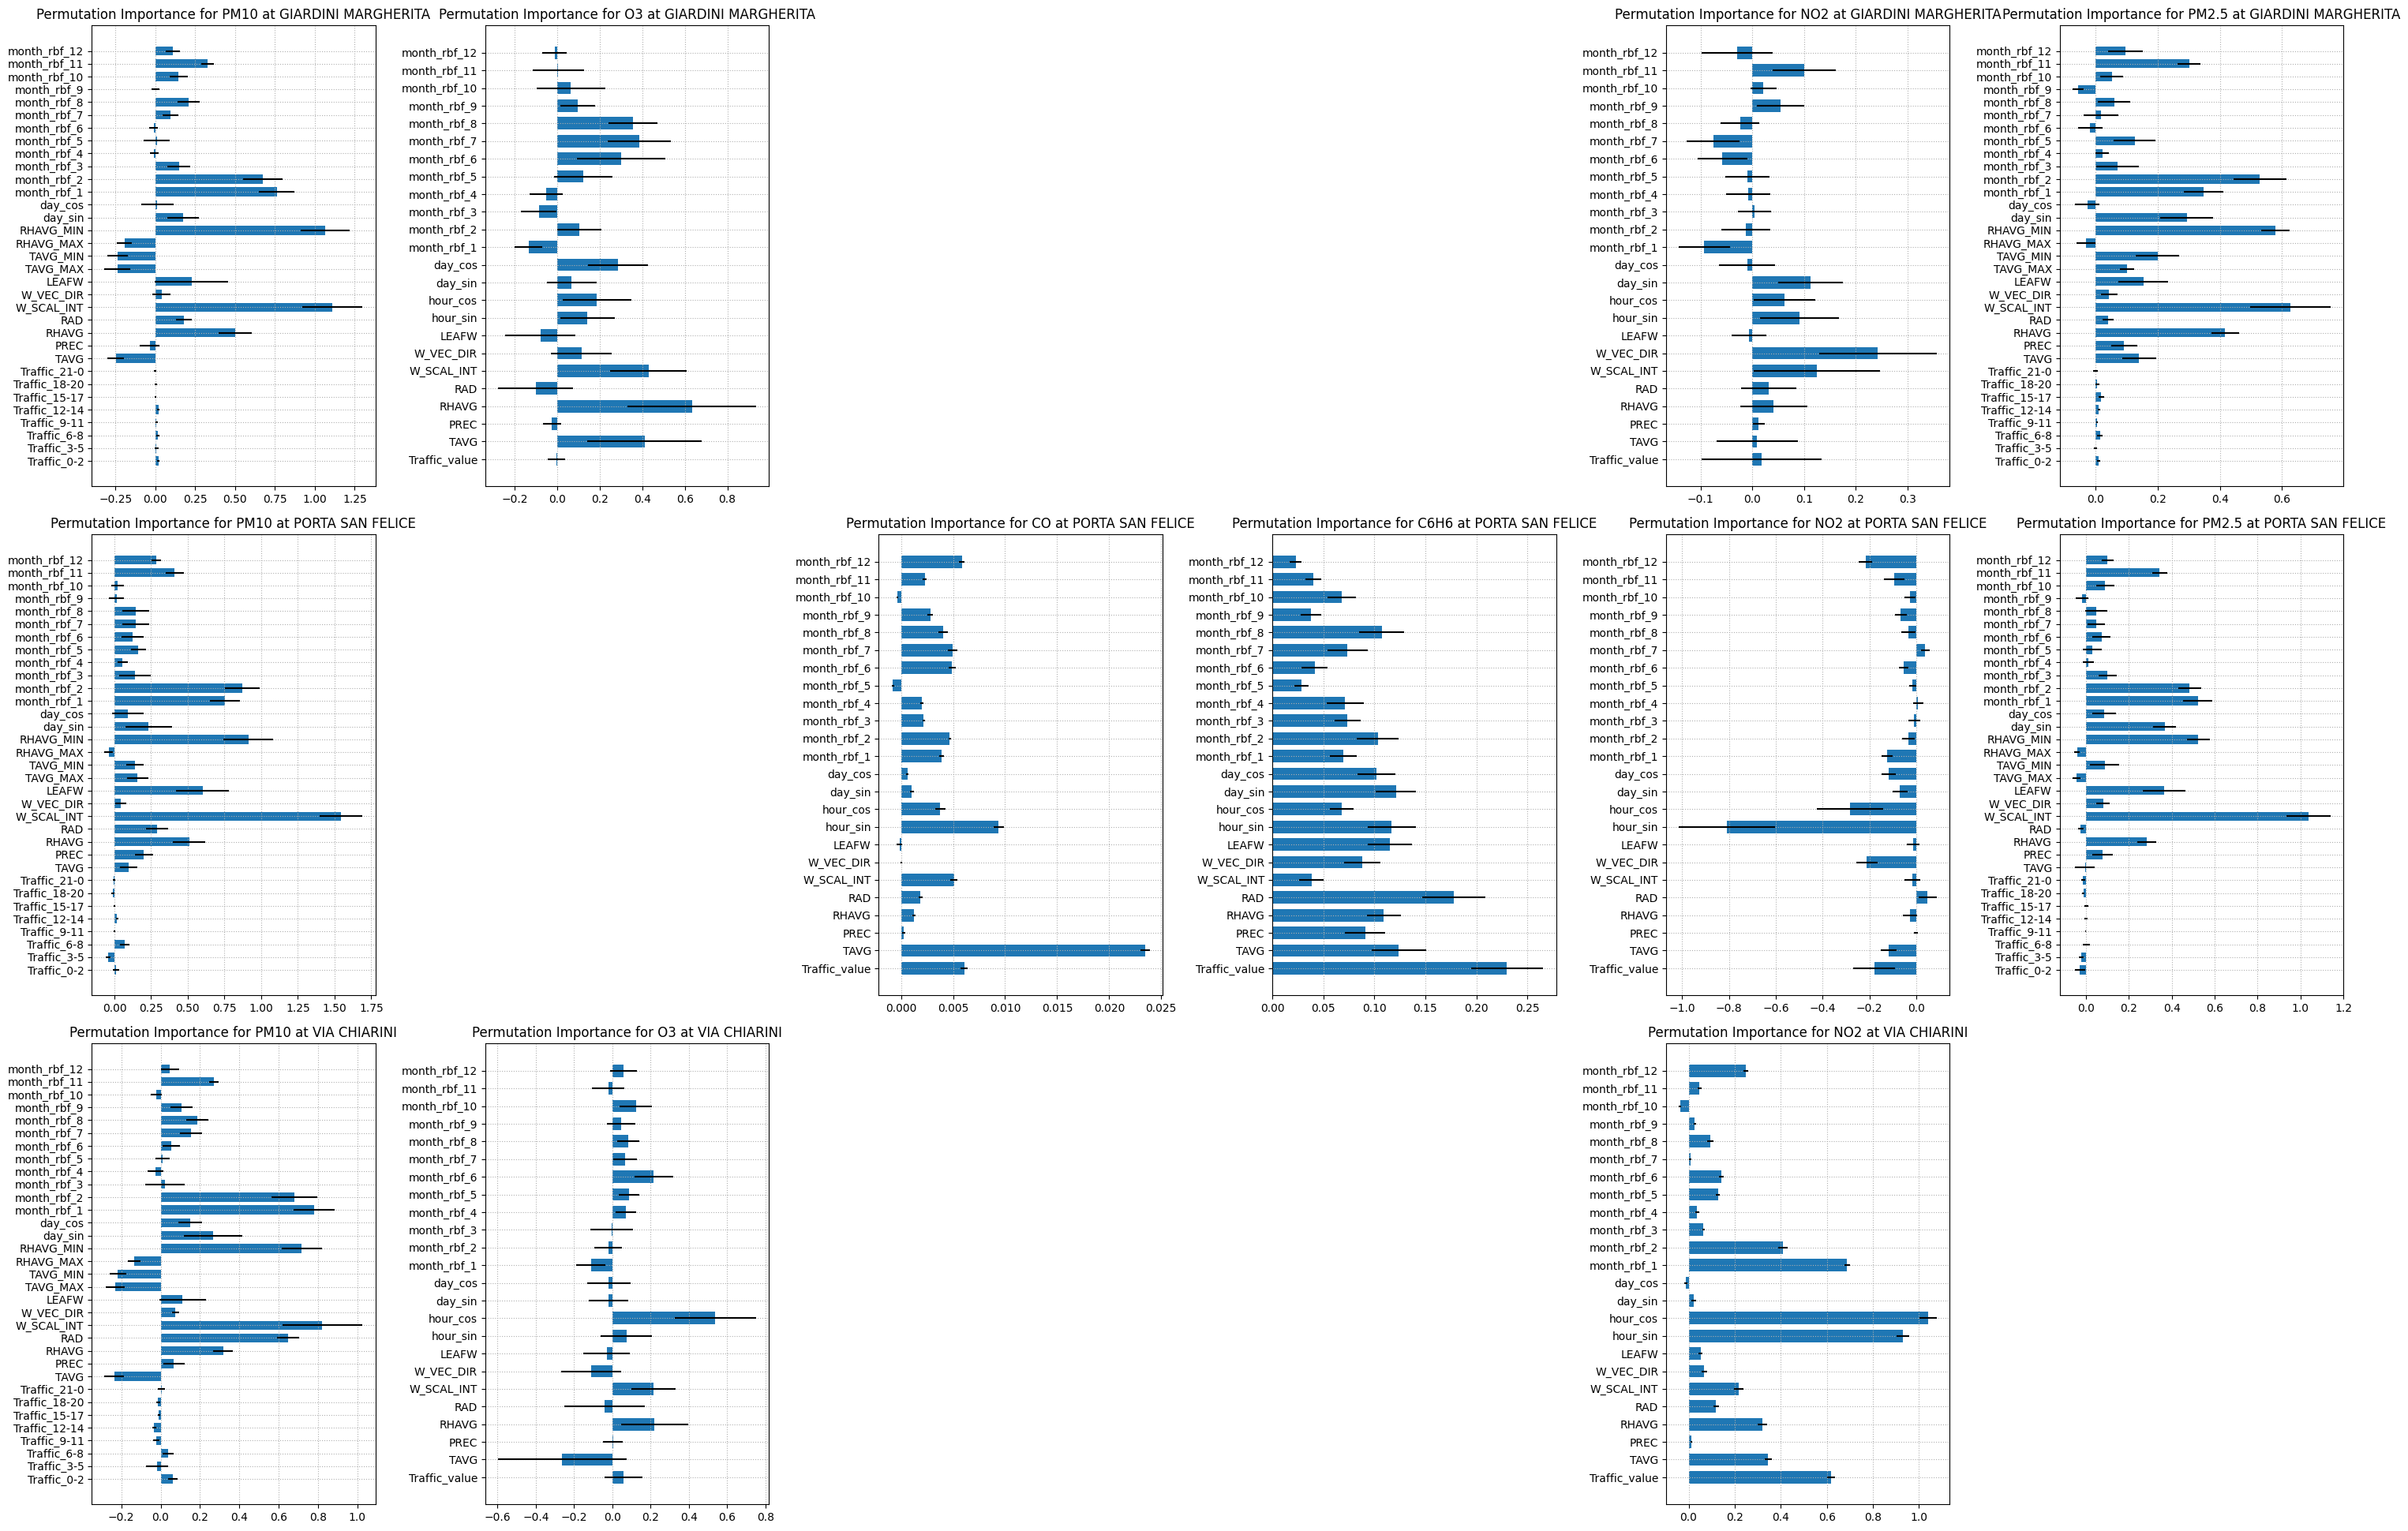

In [71]:
from sklearn.metrics import mean_absolute_error


def neg_mae_scorer(model, X, y):
    try:
        y_pred = model.predict(X, verbose=0)
    except: # sklearn doesnt have verbose
        y_pred = model.predict(X)
    return -mean_absolute_error(y, y_pred)

def lstm_neg_mae_scorer(model, x, y, time_steps, n_features):
    x = x.reshape(-1, time_steps, n_features) # since that this is getting used by permutation_importance, it got 2d data as input and needs to be reshaped
    y_pred = model.predict(x, verbose=0)
    return -mean_absolute_error(y, y_pred)


n_samples = 100 # with this 'low' values I get the same results as higher ones so... lets keep it fast 
n_repeats = 10

n_rows = len(stations)
n_cols = len(agents)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 6.5))

for station in stations:
    if station not in agents_permutation_importance:   
        agents_permutation_importance[station] = {}
    for agent in models[station].keys():
        model = models[station][agent]
        X_test = test_sets[station][agent]['x']
        y_test = test_sets[station][agent]['y']
        features = X_test.columns
        importances = {}
        scoring = neg_mae_scorer
        lstm = False
        input_shape=None

        if isinstance(model, tf.keras.models.Sequential):
            input_shape = model.input_shape
            
            if len(input_shape) == 2: #ffnn or cnn
                # continue
                pass
                
            if len(input_shape) == 3: # lstm
                # continue
                lstm = True
                time_steps = input_shape[1] 
                n_features = input_shape[2] 
                use_mask = isinstance(model.layers[0], tf.keras.layers.Masking)
                X_test, y_test = create_sequences(test_sets[station][agent]['x'], test_sets[station][agent]['y'], time_steps, use_mask=use_mask)
                # X_test, y_test = create_sequences(test_sets[station][agent]['x'].iloc[:3*n_samples], test_sets[station][agent]['y'].iloc[:3*n_samples], time_steps, use_mask=use_mask)
                y_test = y_test.to_numpy()
                test_data_idx = np.random.choice(X_test.shape[0], size=n_samples, replace=False)
                X_test = X_test[test_data_idx]
                y_test = y_test[test_data_idx]
                X_test = X_test.reshape(X_test.shape[0], -1) # permutation_importance does not allow for 3d data

                scoring = lambda model, x, y: lstm_neg_mae_scorer(model, x, y, time_steps, n_features) # lambda bcs we ahd to pass time steps and num. features    
            
        else: # other models
            X_test = X_test.sample(n_samples, random_state=42)
            y_test = y_test.sample(n_samples, random_state=42)

        # print(f'Computing importance for {station} {agent}')

        # compute importances
        importances_result = permutation_importance(model,
                                                    X_test,
                                                    y_test,
                                                    scoring=scoring,
                                                    n_repeats=n_repeats,
                                                    random_state=42)
        
        for key in ('importances_mean', 'importances_std'): # we don't care about the full repetitions values (`importances`)
            val = importances_result[key]
            if lstm: # for the lstm we had to flatten the sequences, now we have one ts*n_feat. total features, so we go back to the original shape averaging
                val = val.reshape(input_shape[1], input_shape[2])
                val = val.mean(axis=0)
            importances[key] = val

        # save the importances
        agents_permutation_importance[station][agent] = importances

        # plot
        ax = axes[stations.index(station)][agents.index(agent)]
        ax.barh(features, importances['importances_mean'], height=0.7, xerr=importances['importances_std'])
        # ax.bar(X_test.columns, importances.importances_mean, width=0.7, yerr=importances.importances_std)
        # ax.set_xticklabels(X_test.columns, rotation=90)
        ax.set_title(f'Permutation Importance for {agent} at {station}')
        ax.grid(linestyle=':')

for station in stations:
    for agent in agents:
        if agent not in models[station]:
            axes[stations.index(station)][agents.index(agent)].axis('off') # remove unused subplots

plt.tight_layout()
# plt.subplots_adjust(hspace=0.5)
plt.show()

## **Explainability with SHAP**

In [9]:
agents_shap_values = {}

In [ ]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import warnings

# shap raises this warning
warnings.filterwarnings(
    "ignore",
    message="`tf.keras.backend.set_learning_phase` is deprecated",
    category=UserWarning,
    module="keras.backend"
)


def model_predict(data): # used in kernel explainers
    return model.predict(data,verbose=0).reshape(-1) # with no reshaping it does not work

n_samples = 200

n_rows = len(stations)
n_cols = len(agents)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 6.5))

for station in stations:
    if station not in agents_shap_values:   
        agents_shap_values[station] = {}
    for agent in models[station].keys():
        model = models[station][agent]
        if isinstance(model, tf.keras.models.Sequential):
            training_data = None
            test_data = None
            shap_values = None
            input_shape = model.input_shape

            if len(input_shape) == 2: # ffnn or cnn
                # continue
                training_data = train_sets[station][agent]['x'].sample(n_samples, random_state=42)
                test_data = test_sets[station][agent]['x'].sample(n_samples, random_state=42)
                
                # deep (doesnt work)
                # explainer = shap.DeepExplainer(model, training_data)
                
                # kernel (has to predict and becomes so slow with many samples)
                # explainer = shap.KernelExplainer(model_predict, training_data)
                # shap_values = explainer.shap_values(test_data)

                # gradient
                explainer = shap.GradientExplainer(model, training_data)
                shap_values = explainer.shap_values(np.array(test_data))
                shap_values = shap_values.squeeze()

            if len(input_shape) == 3: # lstm
                # continue
                time_steps = input_shape[1] 
                use_mask = isinstance(model.layers[0], tf.keras.layers.Masking)
                training_data, _ = create_sequences(train_sets[station][agent]['x'], train_sets[station][agent]['y'], time_steps, use_mask=use_mask)
                test_data, _ = create_sequences(test_sets[station][agent]['x'], test_sets[station][agent]['y'], time_steps, use_mask=use_mask)
                # training_data, _ = create_sequences(train_sets[station][agent]['x'].iloc[:3*n_samples], train_sets[station][agent]['y'].iloc[:3*n_samples], time_steps, use_mask=use_mask)
                # test_data, _ = create_sequences(test_sets[station][agent]['x'].iloc[:3*n_samples], test_sets[station][agent]['y'].iloc[:3*n_samples], time_steps, use_mask=use_mask)
                
                # if you sample before creating the sequences you would separate consecutive values. We might want to sample groups of time_steps elements
                # and then create sequences with no sliding window. Or simply shrinken the dataset before, you need num_samples + time_steps -1 hours in total,
                # so maybe keep 2/3 times num_samples before creating sequences <-- currenty doing this (missing the first `times_steps` -1 elements)
                training_data_idx = np.random.choice(training_data.shape[0], size=n_samples, replace=False)
                test_data_idx = np.random.choice(test_data.shape[0], size=n_samples, replace=False)
                training_data = training_data[training_data_idx]
                test_data = test_data[test_data_idx]

                # deep (doesnt work)
                # explainer = shap.DeepExplainer(model, training_data)
                
                # gradient
                explainer = shap.GradientExplainer(model, training_data)
                shap_values = explainer.shap_values(test_data)
                shap_values = np.mean(np.squeeze(shap_values), axis=1)
                test_data = pd.DataFrame(test_data.mean(axis=1), columns=test_sets[station][agent]['x'].columns)

                # kernel (might work if passed time averaged data, idk tho)
                # explainer = shap.KernelExplainer(model_predict, training_data)
                # shap_values = explainer.shap_values(test_data.reshape(test_data.shape[0], -1))
                # shap_values = explainer.shap_values(test_data)

        elif isinstance(model, RandomForestRegressor):
            # continue
            explainer = shap.TreeExplainer(model)
            test_data = test_sets[station][agent]['x'].sample(n_samples, random_state=42)
            shap_values = explainer.shap_values(test_data)

        z_scores = np.abs((shap_values - shap_values.mean(axis=0)) / shap_values.std(axis=0))
        shap_values = shap_values[(z_scores < 3).all(axis=1)]
        test_data = test_data[(z_scores < 3).all(axis=1)]
        
        # save the shap values
        agents_shap_values[station][agent] = {
            'shap_values': shap_values,
            'explainer':  explainer
        }

        # plot
        ax = axes[stations.index(station)][agents.index(agent)]
        tmp_fig, tmp_ax = plt.subplots(figsize=(5, 4))
        shap.summary_plot(shap_values,
                          test_data,
                          max_display=999,
                          show=False,
                          color_bar=True,
                          rng=42
                          )
        canvas = FigureCanvas(tmp_fig)
        canvas.draw()

        # Convert canvas to image
        image = np.frombuffer(canvas.buffer_rgba(), dtype='uint8')
        image = image.reshape(tmp_fig.canvas.get_width_height()[::-1] + (4,))

        # Show the image on the target subplot
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f'SHAP summary for {agent} at {station}')

        plt.close(tmp_fig)

for station in stations:
    for agent in agents:
        if agent not in models[station]:
            axes[stations.index(station)][agents.index(agent)].axis('off') # remove unused subplots
plt.tight_layout()
plt.show()

In [ ]:
a=3
station = 'PORTA SAN FELICE'
agent = 'C6H6'

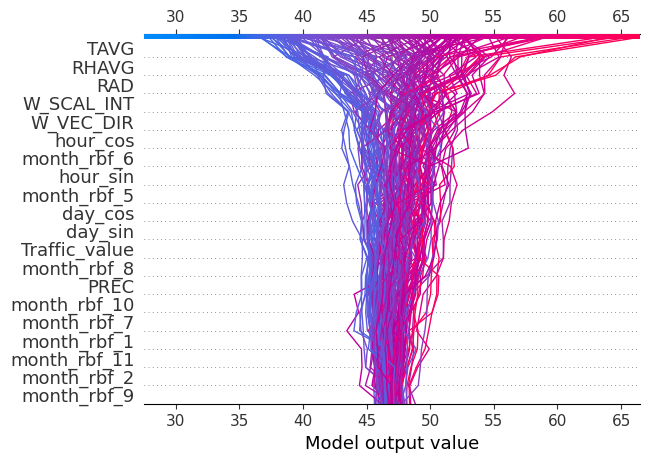

In [ ]:
shaps = agents_shap_values[station][agent]
# plt.figure(figsize=(50,15))
shap.plots.decision(
    np.mean(test_sets[station][agent]['y']),
    shaps['shap_values'],
    feature_names=test_sets[station][agent]['x'].columns.to_numpy(),
    auto_size_plot=False,
)

### SHAP Clustermap

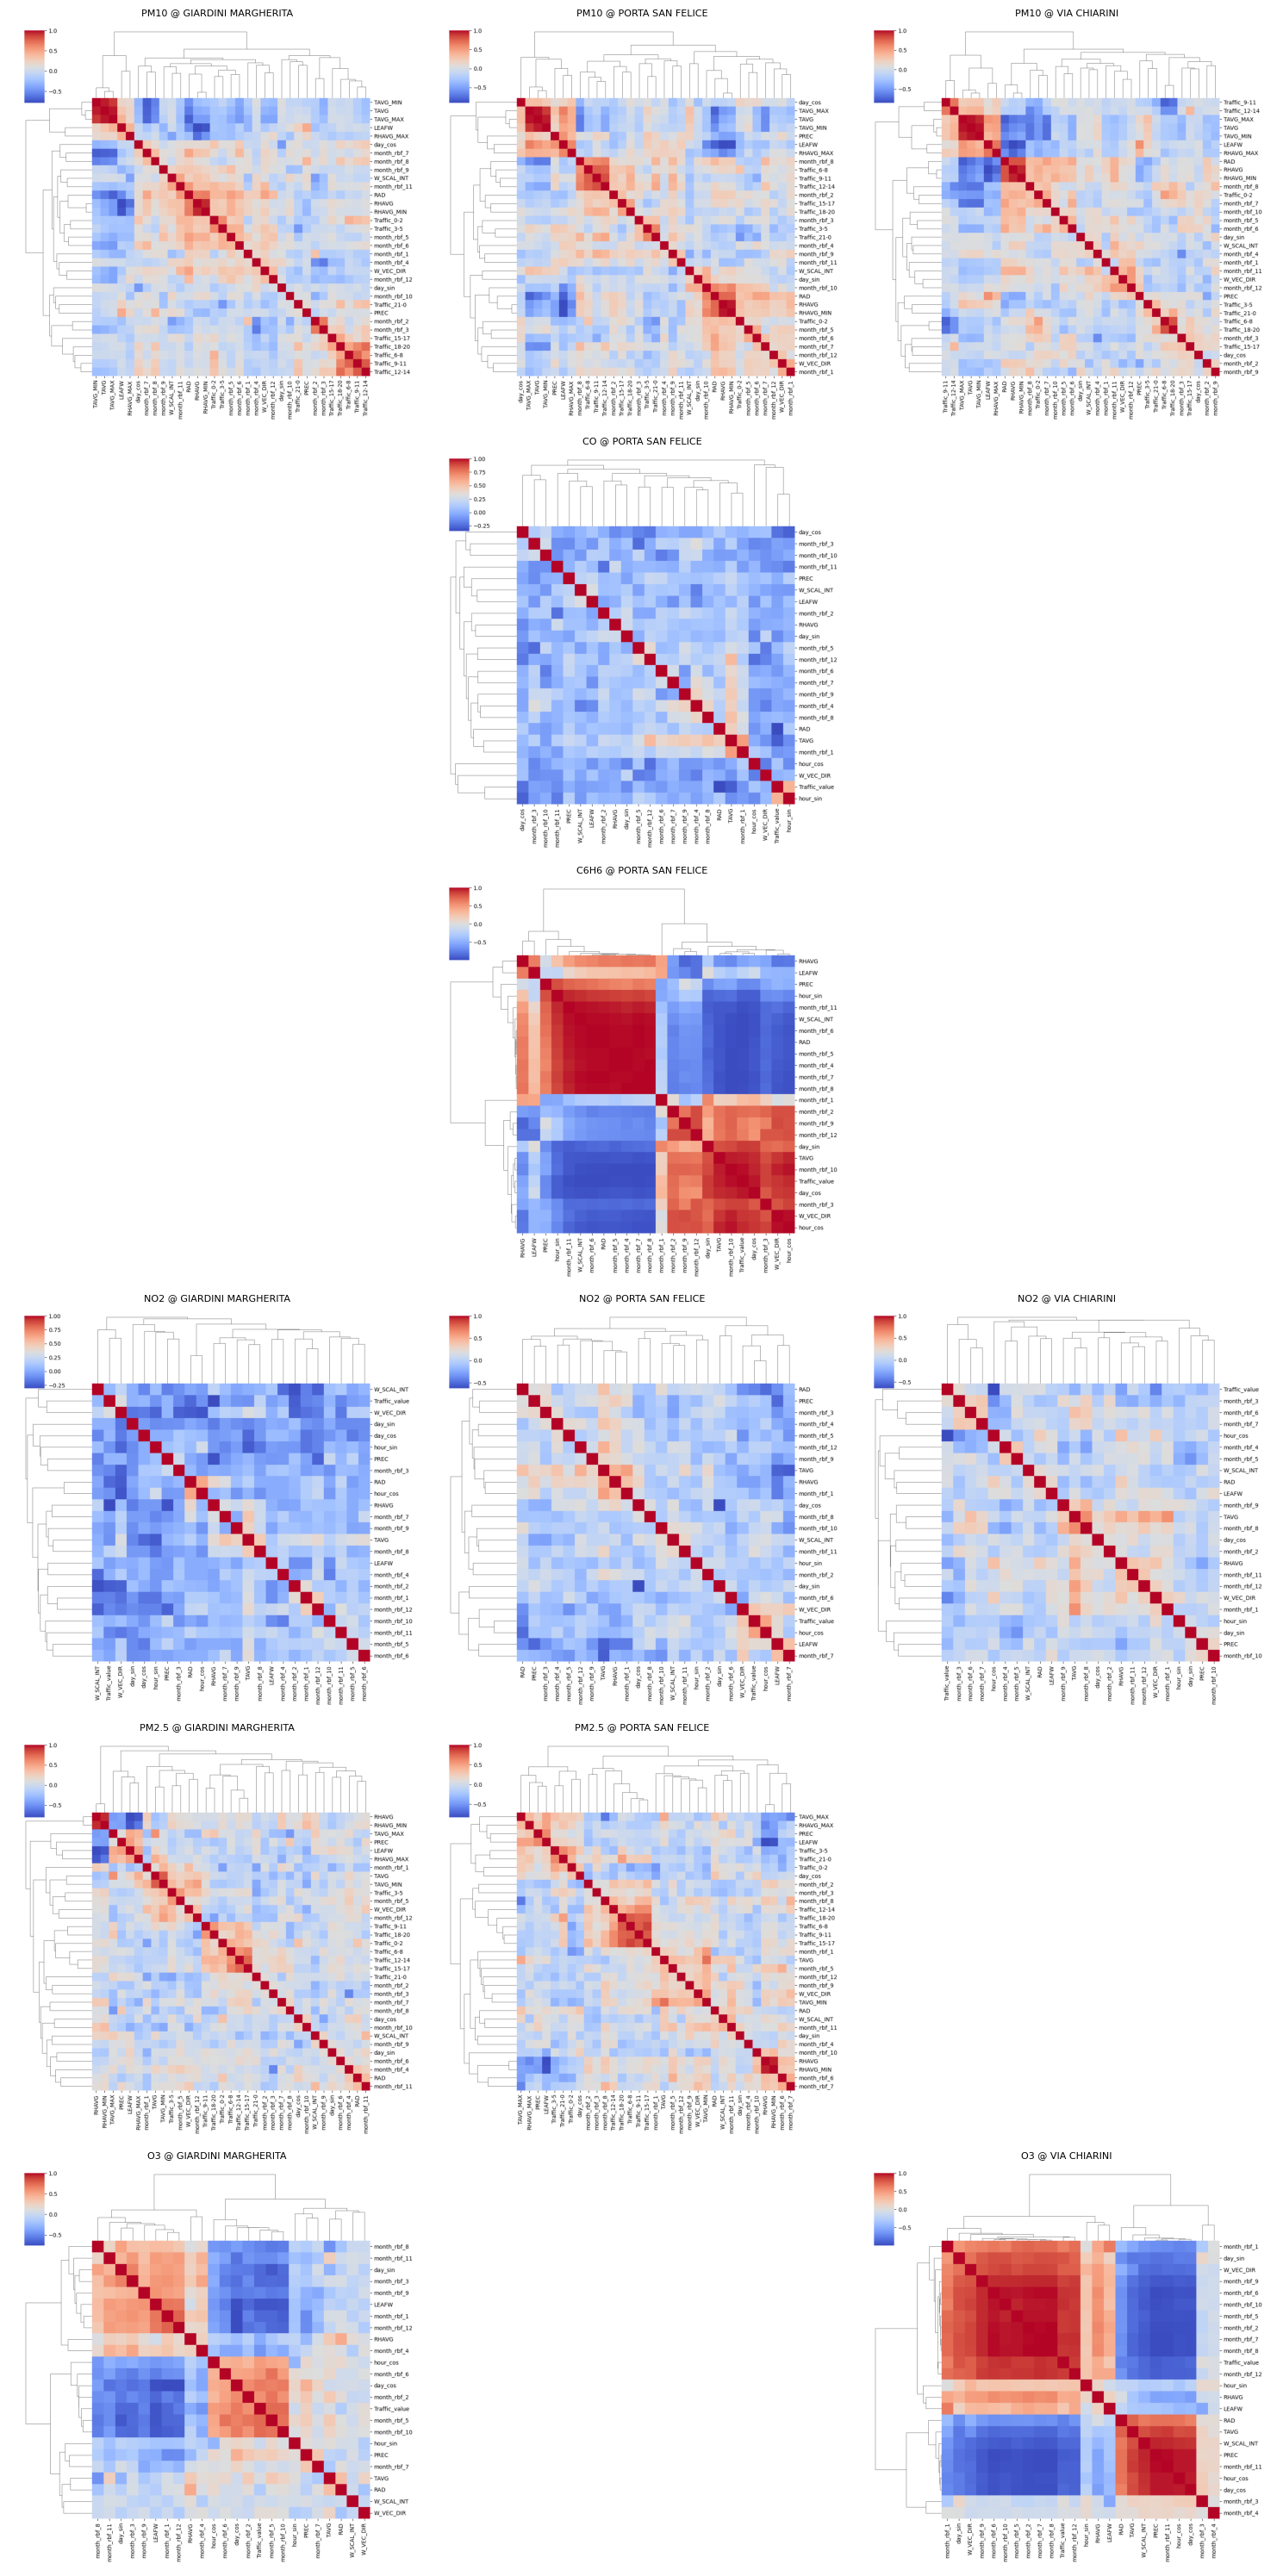

In [ ]:
n_rows = len(agents)
n_cols = len(stations)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))

for station in stations:
    for agent in agents_shap_values[station]:
        ax = axes[agents.index(agent)][stations.index(station)]
        shap_df = pd.DataFrame(agents_shap_values[station][agent]['shap_values'], columns=test_sets[station][agent]['x'].columns)
        tmp_fig = sns.clustermap(
            shap_df.corr(),
            cmap="coolwarm",
            # figsize=(5, 4)
        ).figure

        # Draw to canvas and convert to image
        canvas = FigureCanvas(tmp_fig)
        canvas.draw()
        image = np.frombuffer(canvas.buffer_rgba(), dtype='uint8')
        image = image.reshape(tmp_fig.canvas.get_width_height()[::-1] + (4,))

        # Display image in subplot
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"{agent} @ {station}", fontsize=8)

        plt.close(tmp_fig)
for station in stations:
    for agent in agents:
        if agent not in models[station]:
            axes[agents.index(agent)][stations.index(station)].axis('off') # remove unused subplots
plt.tight_layout()
plt.show()

### SHAP Heatmap

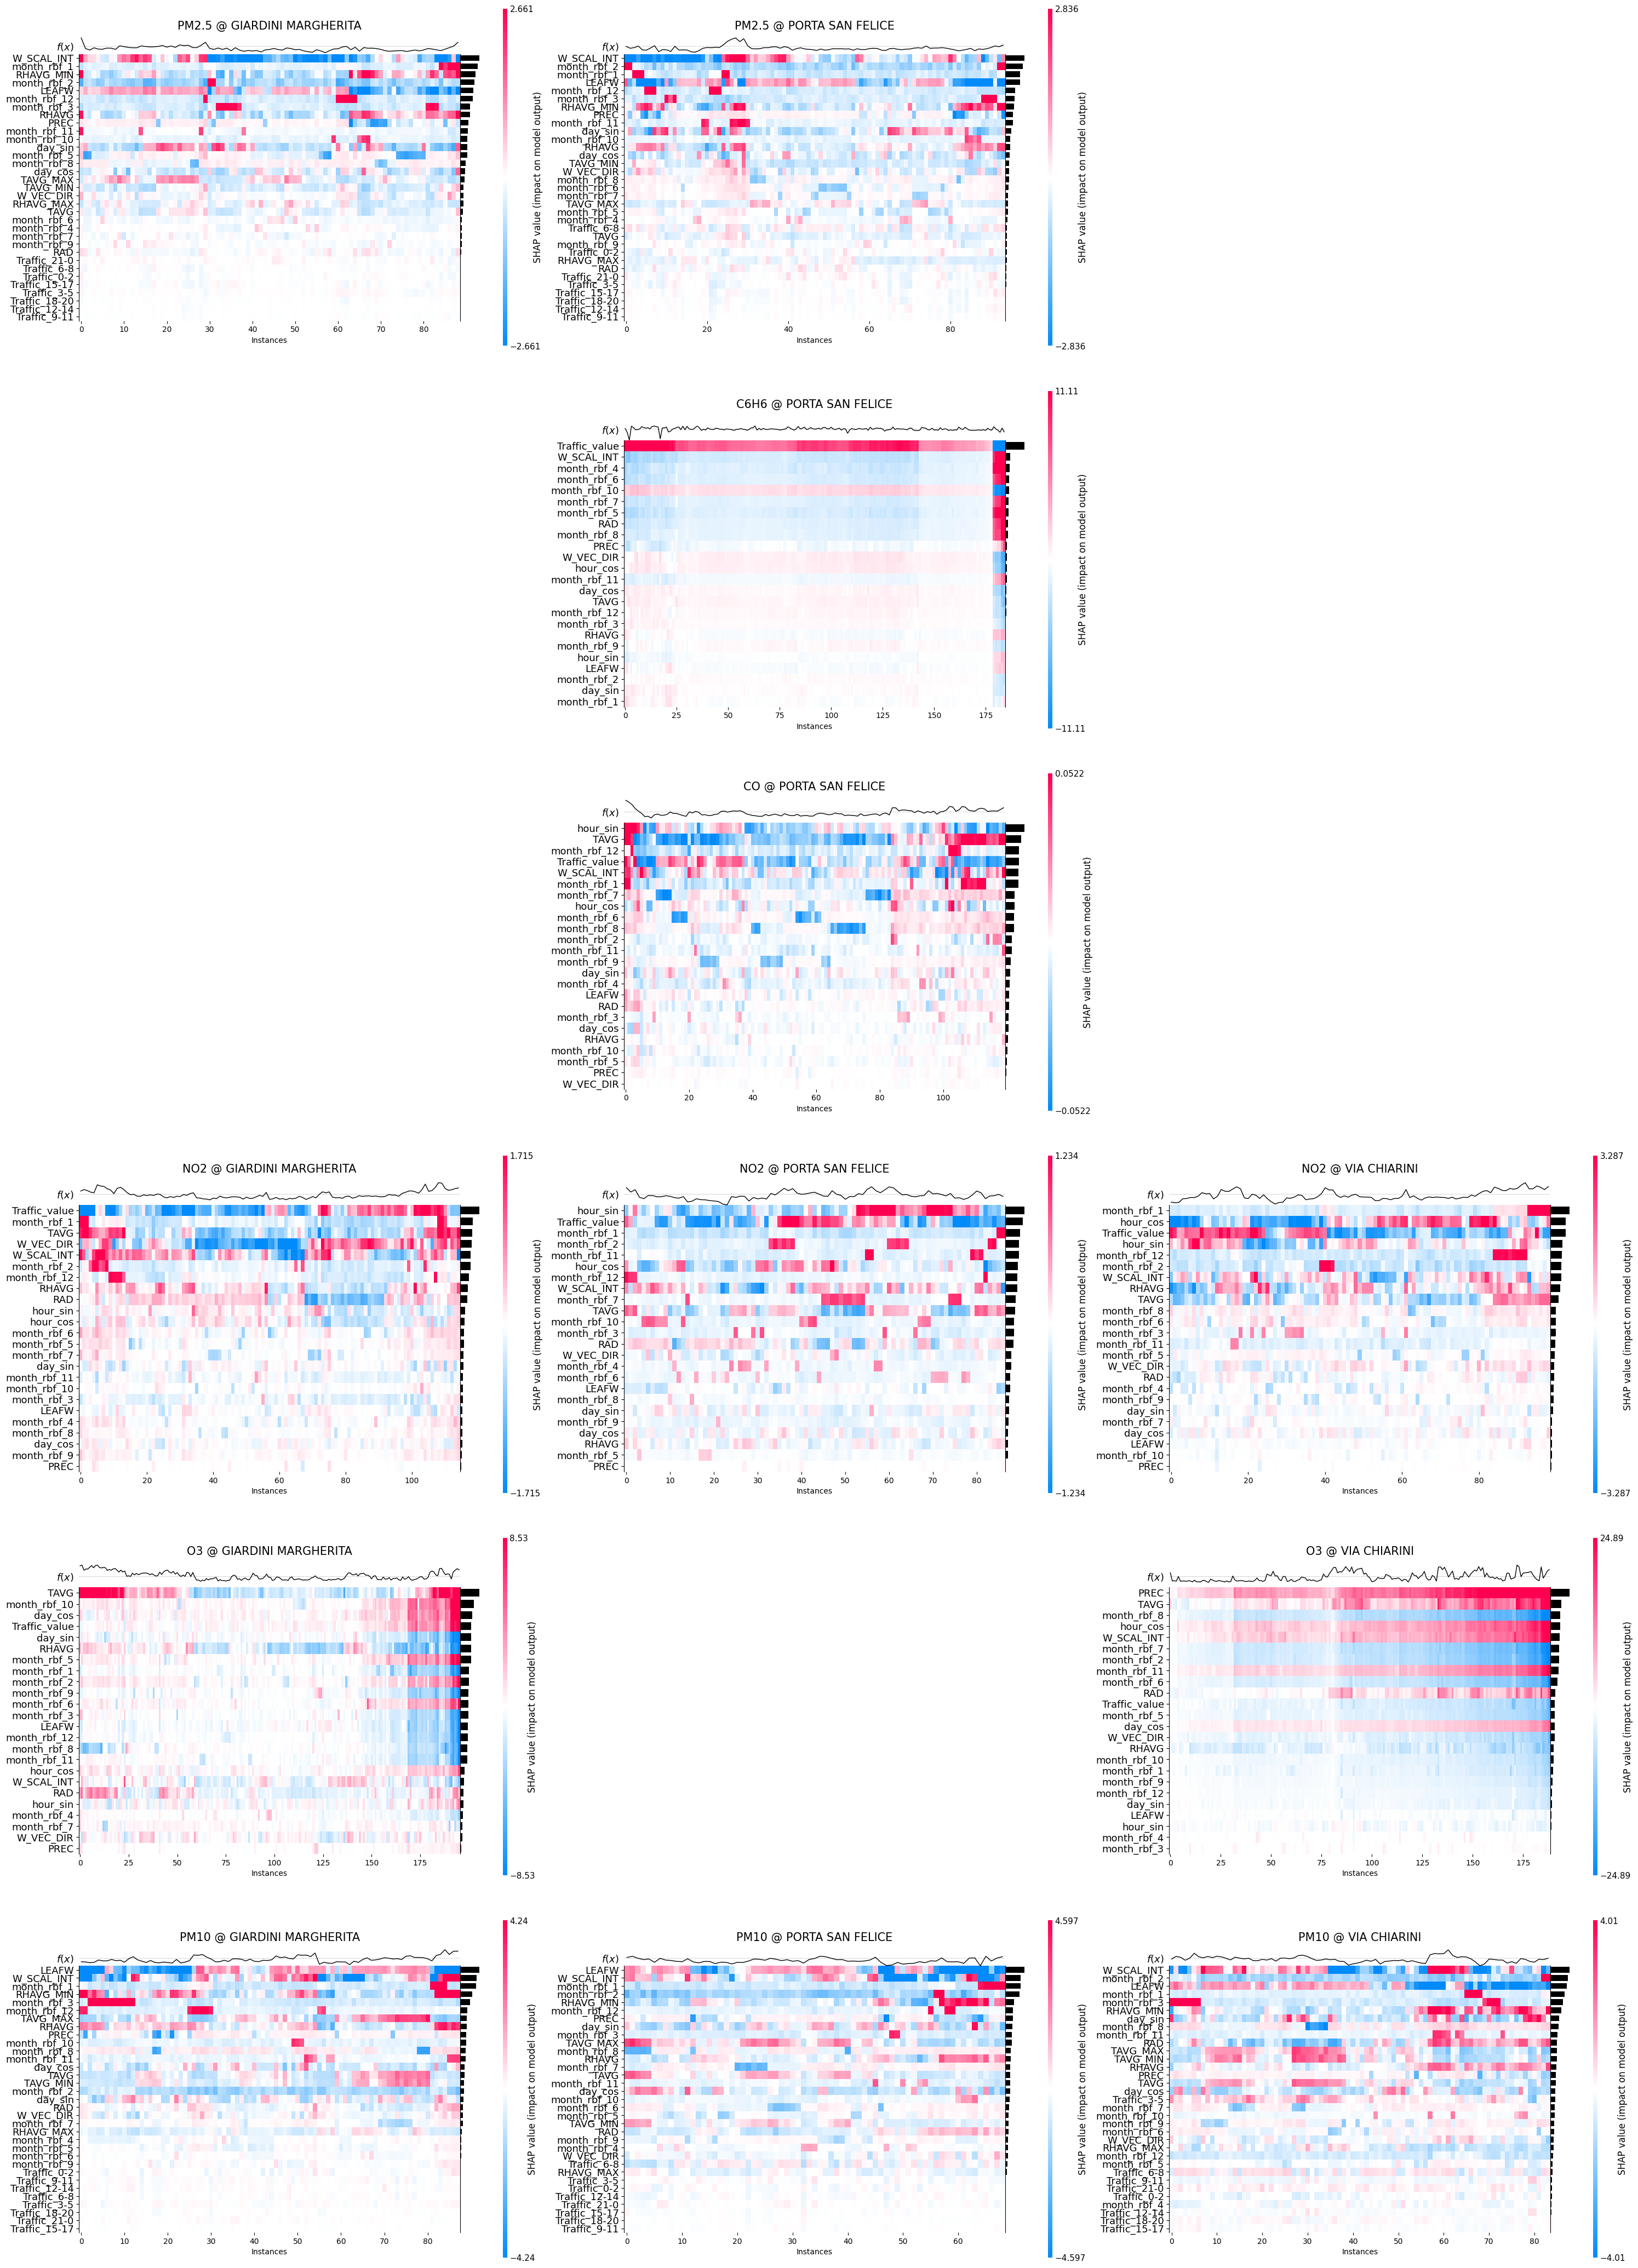

In [62]:
n_rows = len(agents)
n_cols = len(stations)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 10, n_rows * 7))

for station in stations:
    for agent in agents_shap_values[station]:
        explanation = shap.Explanation(
            values=agents_shap_values[station][agent]['shap_values'],
            data=test_sets[station][agent]['x'],
            feature_names=test_sets[station][agent]['x'].columns.tolist()
        )
        # Draw to canvas and convert to image
        ax = axes[agents.index(agent)][stations.index(station)]
        shap.plots.heatmap(
            explanation, 
            feature_values=explanation.abs.max(0), 
            max_display=40,
            plot_width=10,
            show=False,
            ax=ax
        )
        ax.set_title(f"{agent} @ {station}", fontsize=15)

        
for station in stations:
    for agent in agents:
        if agent not in models[station]:
            axes[agents.index(agent)][stations.index(station)].axis('off') # remove unused subplots
plt.tight_layout()
plt.show()

### SHAP Bars

d:\GitHub\AII-project\.venv\lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(


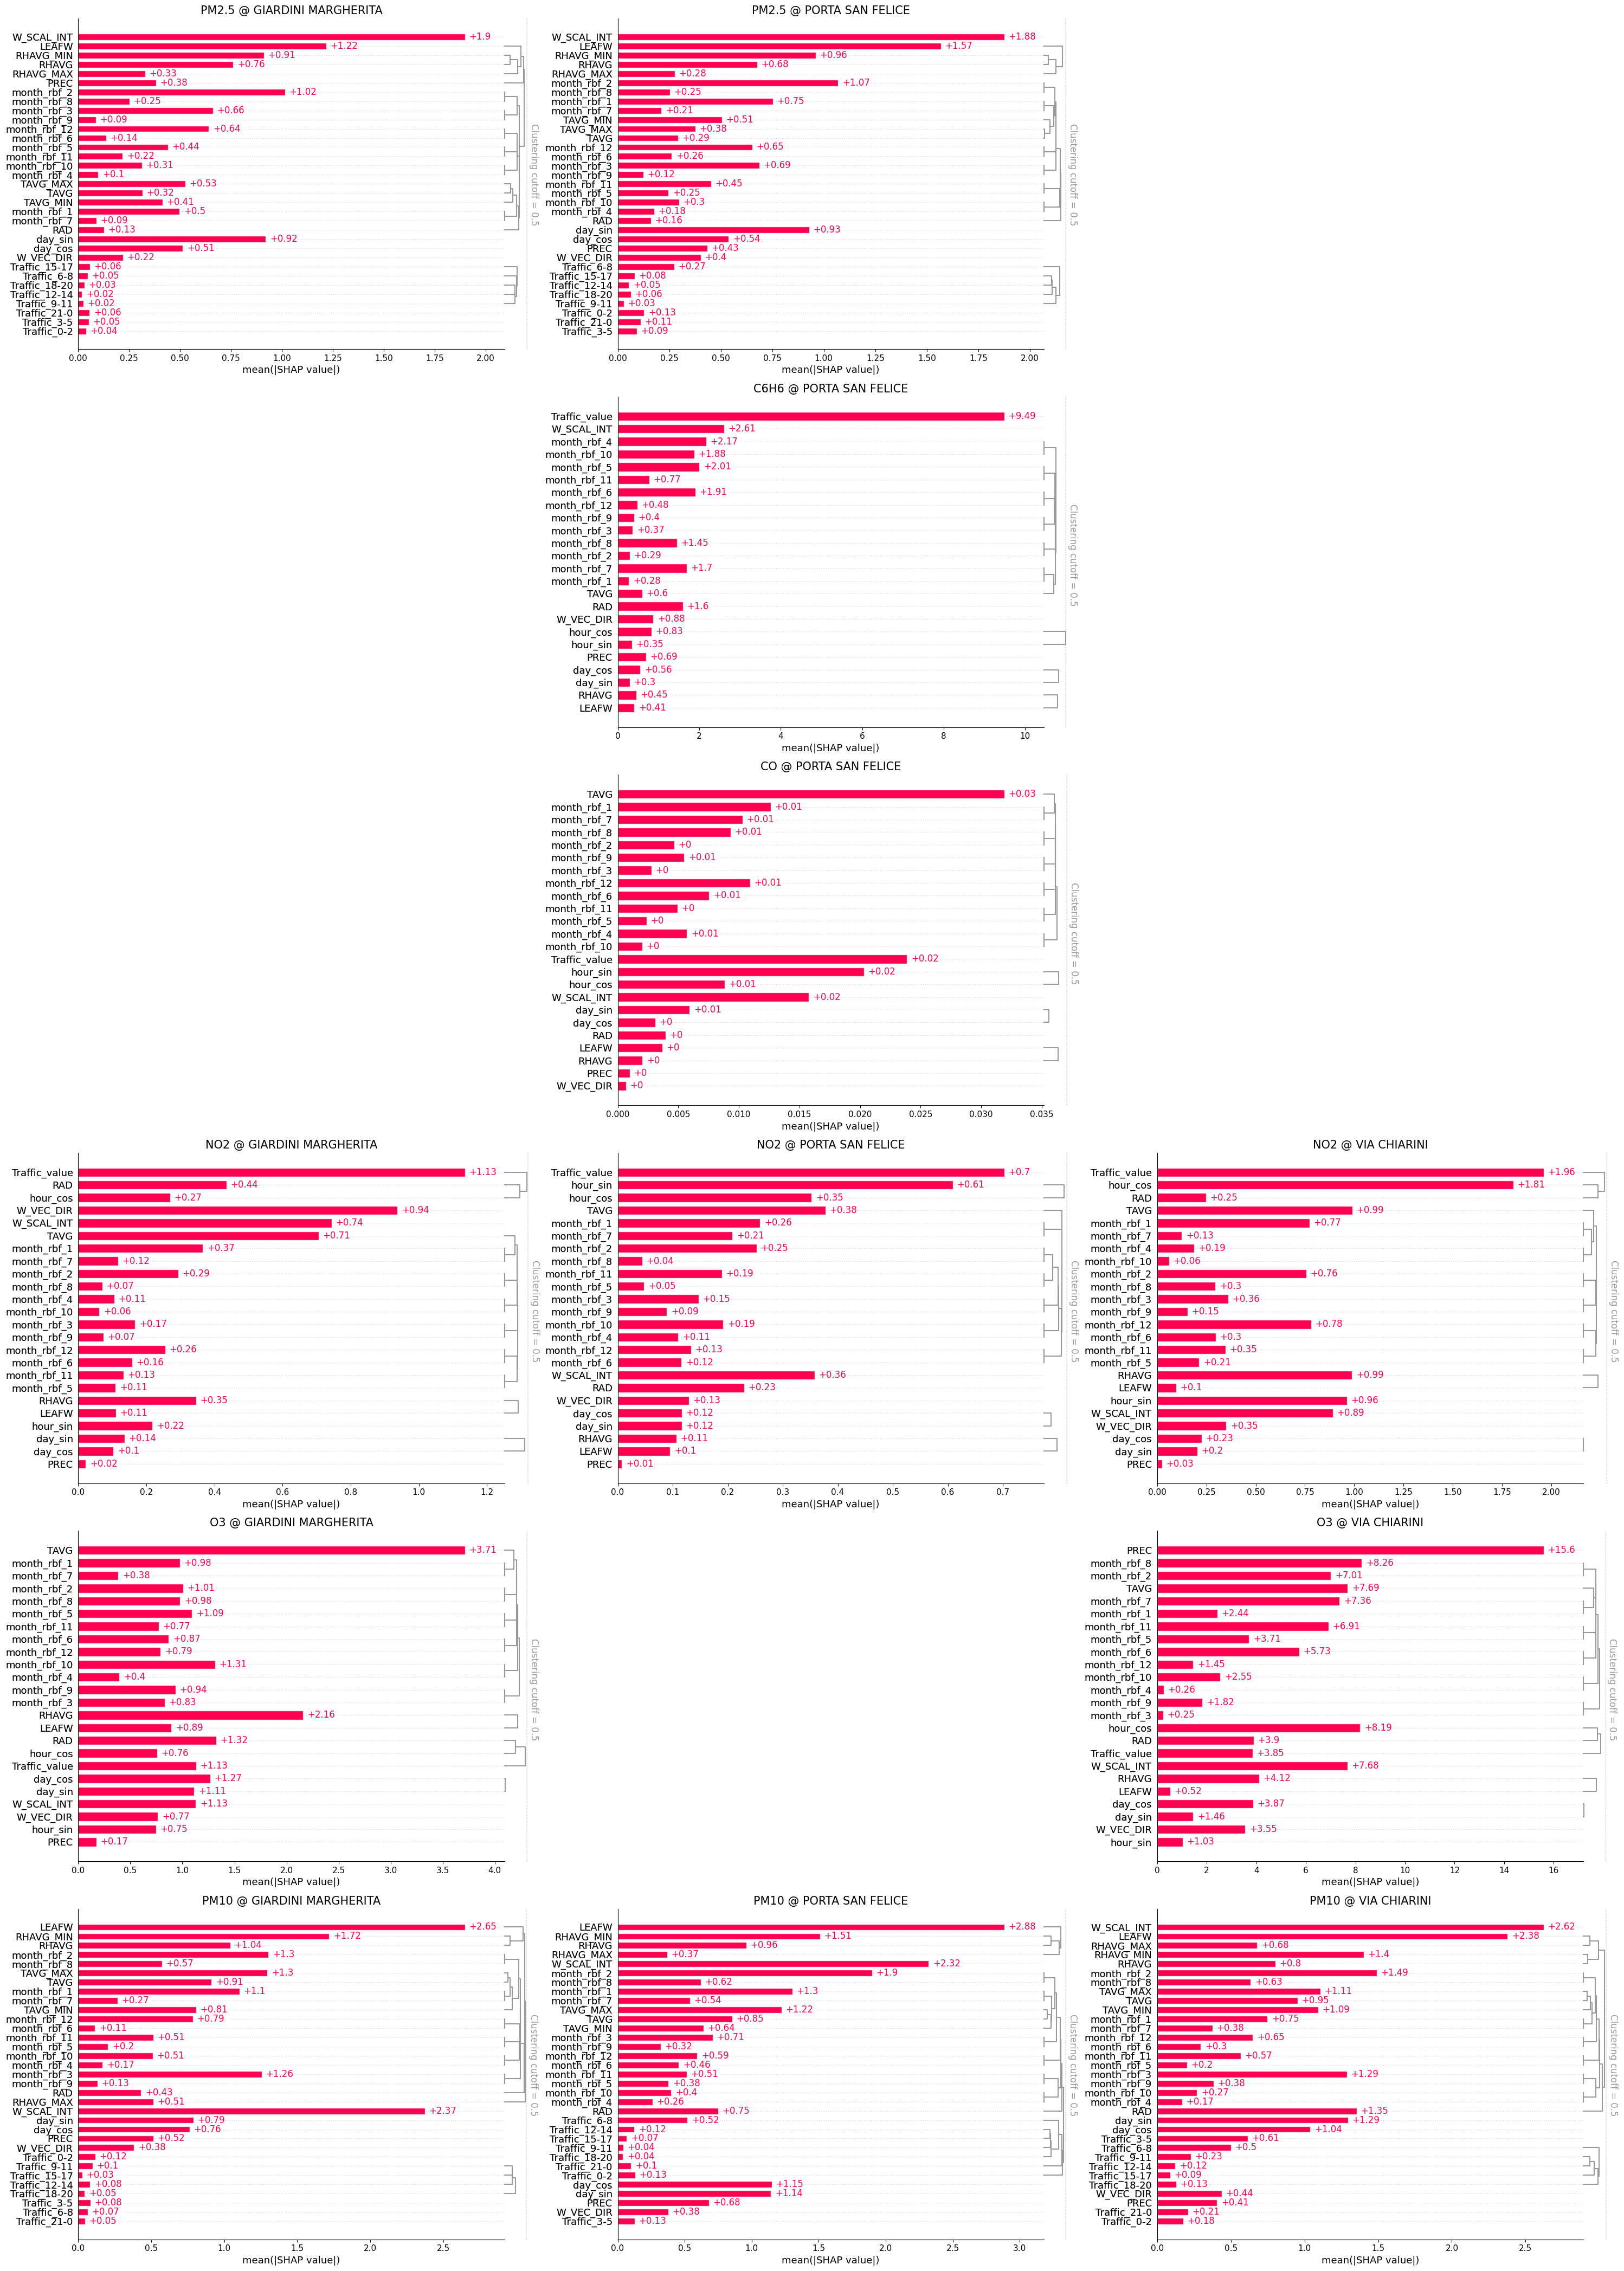

In [66]:
n_rows = len(agents)
n_cols = len(stations)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 10, n_rows * 7))

for station in stations:
    for agent in agents_shap_values[station]:
        explanation = shap.Explanation(
            values=agents_shap_values[station][agent]['shap_values'],
            data=test_sets[station][agent]['x'],
            feature_names=test_sets[station][agent]['x'].columns.tolist()
        )
        clustering = shap.utils.hclust(test_sets[station][agent]['x'], test_sets[station][agent]['y'])
        # Draw to canvas and convert to image
        ax = axes[agents.index(agent)][stations.index(station)]
        shap.plots.bar(
            explanation, 
            clustering=clustering, 
            clustering_cutoff=0.5,
            max_display=40,
            show=False,
            ax=ax
        )
        ax.set_title(f"{agent} @ {station}", fontsize=15)

        
for station in stations:
    for agent in agents:
        if agent not in models[station]:
            axes[agents.index(agent)][stations.index(station)].axis('off') # remove unused subplots
plt.tight_layout()
plt.show()

Distance in the clustering is assumed to be scaled roughly between 0 and 1, where 0 distance means the features perfectly redundant and 1 means they are completely independent

## Results

In [23]:
shap_feature_importance = extract_ordered_features_by_shap(agents_shap_values, test_sets)
print('shap_feature_importance = {')
for station in shap_feature_importance:
    print(f"'{station}': {{")
    for agent in shap_feature_importance[station]:
        print(f"       '{agent}': [", end='')
        print(', '.join([f"'{e}'" for e in shap_feature_importance[station][agent]]),'],')
    print('    },')
print('}')

shap_feature_importance = {
'GIARDINI MARGHERITA': {
       'NO2': ['Traffic_value', 'W_VEC_DIR', 'W_SCAL_INT', 'TAVG', 'RAD', 'month_rbf_1', 'RHAVG', 'month_rbf_2', 'hour_sin', 'hour_cos', 'month_rbf_12', 'month_rbf_11', 'day_cos', 'day_sin', 'month_rbf_9', 'month_rbf_5', 'month_rbf_8', 'month_rbf_7', 'month_rbf_6', 'month_rbf_3', 'LEAFW', 'month_rbf_4', 'month_rbf_10', 'PREC' ],
       'O3': ['TAVG', 'RHAVG', 'W_SCAL_INT', 'RAD', 'W_VEC_DIR', 'hour_sin', 'month_rbf_10', 'day_cos', 'Traffic_value', 'day_sin', 'hour_cos', 'month_rbf_9', 'month_rbf_1', 'LEAFW', 'month_rbf_6', 'month_rbf_11', 'month_rbf_5', 'month_rbf_2', 'month_rbf_8', 'month_rbf_12', 'month_rbf_7', 'month_rbf_3', 'month_rbf_4', 'PREC' ],
       'PM10': ['LEAFW', 'W_SCAL_INT', 'RHAVG_MIN', 'month_rbf_3', 'month_rbf_2', 'TAVG_MAX', 'month_rbf_1', 'RHAVG', 'TAVG', 'day_cos', 'day_sin', 'TAVG_MIN', 'month_rbf_12', 'month_rbf_11', 'RHAVG_MAX', 'month_rbf_8', 'PREC', 'month_rbf_10', 'RAD', 'W_VEC_DIR', 'month_rbf_7', 'month_

We can notice that:
- PM models tend to have an strong correlation between variables like TAVG and TAVG-MAN/MIN. Also, some traffic values tend to be aggregated, while other doesn't
- O3 and C6H6 shows a really big clustering of the shap values with features that have a mostly monotonic impact on the predictions. In the case of benzene, the data seems quite flat.
- both shap values and permutation importance shows  that some features, like traffic temperature and the date, are usually more rilevant than the others.
- In the case if the permutaiton importance of the Conv model, it almost seems like the sign of the values is flipped.
- the clustering using cluster map is seimilar to the one presented by the bars plots, and we can fix a threshold to display highly similar features

We might want to remove overly correlated shap features, since that it means that the using one or the other is actually the same, for the model.
In the case of major clustering we might want to inpsect it further, maybe using an explainer on a tree models.
Binning the traffic doesn't look like an awful idea, maybe we can always also keep the total traffic aswell.